# **Machine Learning Group Project:** Data Exploration and Feature Engineering 

Make sure to **only run this notebook once the previous notebooks [a_csv_creation.ipynb](a_csv_creation.ipynb) and [b_recommender_system.ipynb](b_recommender_system.ipynb) have been run at least once.** 

If those notebooks have both been run at least once, the kernel may be restarted before running this in order to obtain better performance and vaster machine memory.

## Importing Packages 

In [2]:
import ast
import csv
import datetime
import pandas as pd
import numpy as np
from datetime import datetime

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# From sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, mean_squared_error
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, KBinsDiscretizer, OrdinalEncoder

## Reading DataFrames

In [22]:
# Import the final DataFrame
final_df = pd.read_csv("data/final_df.csv")

# Import the Similarity DataFrame
similarity_df = pd.read_csv("data/content_base.csv", index_col = "title")

In [24]:
# Rearrange Columns
final_df = final_df.reindex(columns = ["review_id", "y", "date", "funny", "helpful",
                                       "app_id", "title", "date_release", "rating", 
                                       "positive_ratio", "user_reviews", "win", "mac", "linux", 
                                       "price_final", "price_original", "discount",
                                       'english', 'publisher', 'required_age', 
                                       'achievements', 'average_playtime', 
                                       'median_playtime', "owners", "steam_deck",
                                       "user_id", "products", "reviews", "hours"])

# Sort by Review ID
final_df.sort_values(by=["review_id"], inplace = True)

In [4]:
similarity_df.head(3)

,Counter-Strike,Team Fortress Classic,Day of Defeat,Deathmatch Classic,Half-Life: Opposing Force,Ricochet,Half-Life,Counter-Strike: Condition Zero,Half-Life: Blue Shift,Half-Life 2,...,Homeless Simulator,Nyasha Valkyrie,Blacksmith Run,6120,12 HOURS,The Mystery of Bikini Island,CaptainMarlene,Room of Pandora,Cyber Gun,Rune Lord
name,,,,,,,,,,,,,,,,,,,,,
Counter-Strike,1.000000,0.670114,0.465331,0.590170,0.369035,0.592202,0.550576,0.591619,0.273407,0.317982,...,0.046907,0.044606,0.085650,0.054682,0.162151,0.000286,0.071484,0.054515,0.249673,0.000037
Team Fortress Classic,0.670114,1.000000,0.459269,0.643172,0.354177,0.595132,0.510027,0.544387,0.267601,0.268686,...,0.030936,0.038805,0.086308,0.047549,0.151358,-0.000019,0.072817,0.047453,0.271533,0.011505
Day of Defeat,0.465331,0.459269,1.000000,0.428081,0.344162,0.382637,0.383642,0.491293,0.241361,0.211995,...,0.130128,0.045168,0.144044,0.089401,0.101037,0.026188,0.084883,0.036662,0.214531,0.053497


## Data Exploration

#### Target Variable Exploration

First we explore the distribution of our target variable _y_, which is a column of booleans which signal whether a given user would recommend a given game or not.

In creating a countplot, we find that the dataset is rather unbalanced. Only 14.12% of observations is negative, while the remaining 85.88% is positive. This will certainly be kept in consideration when training our model, as the unbalance must be offset. With a quick calculation, we find that the ratio of positives to negatives is 6.08 approximately.

<Figure size 1000x500 with 0 Axes>

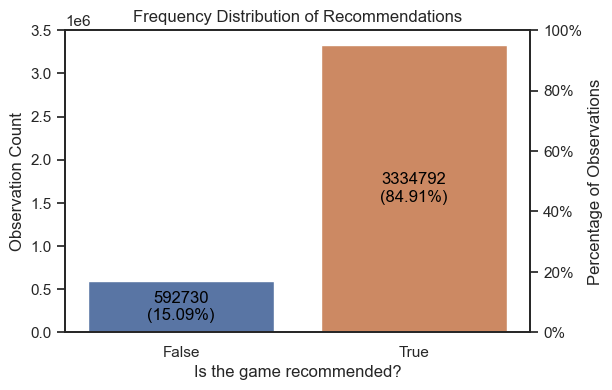

In [47]:
# Plotting the frequency distribution of number of recommendations
plt.figure(figsize=(10, 5))
plt.figure(dpi=100)

ax = sns.countplot(x='y', data=final_df)

plt.title('Frequency Distribution of Recommendations')
plt.xlabel('Is the game recommended?')
plt.ylabel('Observation Count')

# Calculate percentage of each category
percentages = final_df['y'].value_counts(normalize=True) * 100

# Annotate the bars with counts and percentages
for p in ax.patches:
    count = int(p.get_height())
    percentage = percentages.sort_values()[int(p.get_x() + p.get_x())]
    ax.annotate(f'{count}\n({percentage:.2f}%)', 
                (p.get_x() + p.get_width() / 2., p.get_height() / 2),
                ha='center', va='center', fontsize=12, color='black')

# Add percentage axis
ax2 = ax.twinx()
ax2.set_ylim(0, 100)
ax2.set_ylabel('Percentage of Observations')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()

In [48]:
print("The \033[1mratio of positive to negative recommendations\033[0m is", 
     final_df['y'].value_counts()[0] / final_df['y'].value_counts()[1])

The ratio of positive to negative recommendations is 0.1777412204419346


#### Steam Rating Exploration

Reamining within the realm of ratings, we explore the distribution of the Steam rating system through a frequency table. Very interestingly, we observe that many of the rating categories are not in fact present in our data. It would seem that there are no games with overall negative reviews, while most games either have a _Very Positive_ or _Overwhelmingly Positive_ rating (appr. 86.24%). All in all, this is in line with the previous observation concerning the unbalanced dataset. 

Another noteworthy aspect of the dataset is that there are no _Positive_ reviews. The remaining 13.76% is split between _Mostly Positive_ and _Mixed_, with the former counting more observation than the latter. It is worth remembering that the Steam rating system assigns the _Positive_ rating to games that seem to have good ratings, but a review count which is not high enough to really "consacrate" its status as a very positively (or overwhlemingly positively) rated game. This perhaps informs us on the type of game which tends to be included in these datasets, focusing on larger more "mainstream" products rather than smaller lesser-known ones.

In [49]:
# Create a frequency table
rating_counts = pd.DataFrame(final_df['rating'].value_counts())

# Rename the columns
rating_counts.columns = ['Observation Count']

# Sort the rows based on the order of rating categories
rating_order = ["Overwhelmingly Positive", "Very Positive", "Positive", 
                "Mostly Positive", "Mixed", "Mostly Negative", 
                "Negative", "Very Negative", "Overwhelmingly Negative"]

rating_counts = rating_counts.reindex(rating_order)

# Fill NaN with 0
rating_counts.fillna(0, inplace = True)

# Add a column for percentage of observations
rating_counts['Percentage of Observations'] = rating_counts['Observation Count'] / len(final_df) * 100

# Format the percentage column
rating_counts['Percentage of Observations'] = rating_counts['Percentage of Observations'].map('{:.2f}%'.format)

# Turn to Integer
rating_counts["Observation Count"] = [int(i) for i in rating_counts["Observation Count"]]

display(rating_counts)

,Observation Count,Percentage of Observations
Overwhelmingly Positive,1559085,23.75%
Very Positive,4102406,62.49%
Positive,0,0.00%
Mostly Positive,751426,11.45%
Mixed,152006,2.32%
Mostly Negative,0,0.00%
Negative,0,0.00%
Very Negative,0,0.00%
Overwhelmingly Negative,0,0.00%


#### Owners Exploration

AAAAA

<Figure size 1000x500 with 0 Axes>

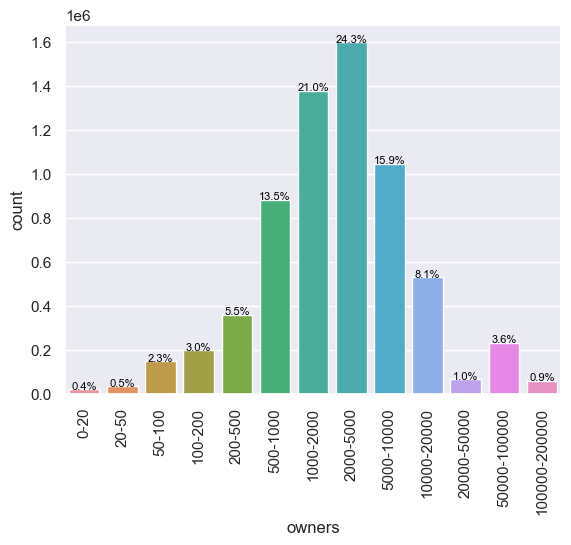

In [12]:
# Create Order
order_list = ["0-20", "20-50", "50-100", "100-200", "200-500",
              "500-1000", "1000-2000", "2000-5000", "5000-10000",
              "10000-20000", "20000-50000", "50000-100000", 
              "100000-200000"]

# Plotting the frequency distribution of number of recommendations
sns.set_theme()
plt.figure(figsize=(10, 5))
plt.figure(dpi=100)
plt.xticks(rotation=90)

ax = sns.countplot(x='owners', data=final_df,
                  order = order_list)

# Add percentages to plot
total = len(final_df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height() + 30
    ax.annotate(percentage, (x, y), ha='center', fontsize=8, color='black')
    
plt.show()

<Figure size 1000x500 with 0 Axes>

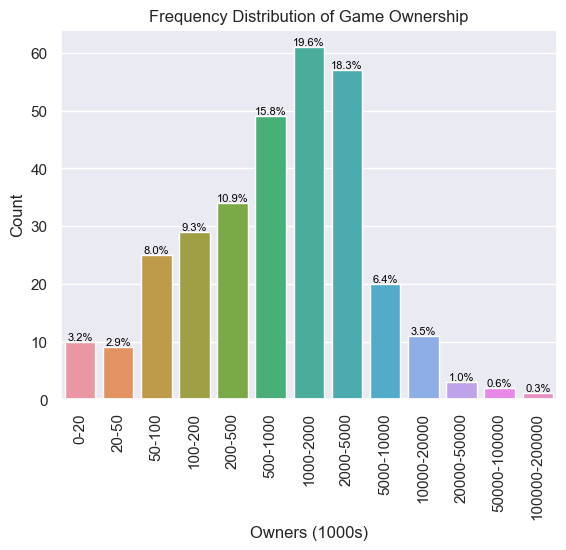

In [15]:
# Drop duplicates based on app_id
final_df = final_df.drop_duplicates(subset=['app_id'])

# Create Order
order_list = ["0-20", "20-50", "50-100", "100-200", "200-500",
              "500-1000", "1000-2000", "2000-5000", "5000-10000",
              "10000-20000", "20000-50000", "50000-100000", 
              "100000-200000"]

# Plotting the frequency distribution of number of recommendations
sns.set_theme()
plt.figure(figsize=(10, 5))
plt.figure(dpi=100)
plt.xticks(rotation=90)

ax = sns.countplot(x='owners', data=final_df,
                  order = order_list)

# Add percentages to plot
total = len(final_df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height() + (total/1000)
    ax.annotate(percentage, (x, y), ha='center', fontsize=8, color='black')
    
# Add axis labels and title
plt.xlabel('Owners (1000s)')
plt.ylabel('Count')
plt.title('Frequency Distribution of Game Ownership')

plt.show()

**Correlation Matrix**

/var/folders/gs/xnyw__p94xl1dp76b2zhm0yw0000gn/T/ipykernel_57300/343985717.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analyze['rating'] = df_analyze['rating'].map(rating_map)
/var/folders/gs/xnyw__p94xl1dp76b2zhm0yw0000gn/T/ipykernel_57300/343985717.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analyze['y'] = df_analyze['y'].map({True: 1, False: 0})


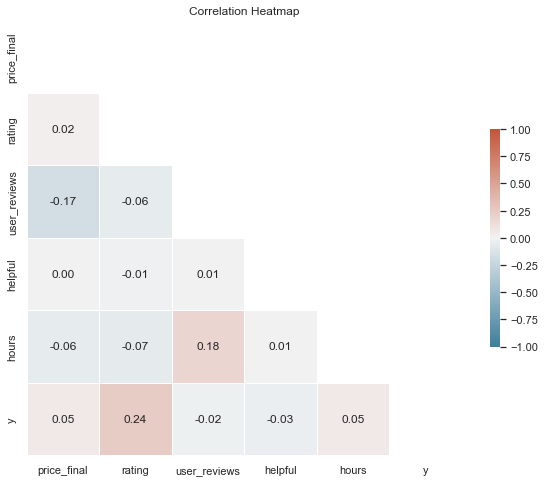

In [35]:
# correlations between different variables, such as price and rating, user reviews and helpful votes, or hours played and recommendation status.

df_analyze = final_df[['price_final', 'rating', 'user_reviews', 'helpful', 'hours', 'y']]

# Convert rating column to numerical values
rating_map = {'Overwhelmingly Positive': 5,
            'Very Positive': 4,
            'Mostly Positive': 3,
            'Mixed': 2,
            'Mostly Negative': 1,
            'Very Negative': 0}

df_analyze['rating'] = df_analyze['rating'].map(rating_map)

# Convert is_recommended column to binary values
df_analyze['y'] = df_analyze['y'].map({True: 1, False: 0})

# Calculate the correlation matrix
corr_matrix = df_analyze.corr()

# Setting seaborn style
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

f, ax = plt.subplots(figsize=(10, 8))


cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


As expected, be observe the strongest positive correlations between y (recommendation status) and rating and user_reviews and hours. Hours and y (recommendation status) are also slightly correlated.
The final price seems to have a negative influence on user_reviews and the rating. 

The correlations will become usefull when building the models later and deciding what features to add to a model.

**Frequency Distribution of Final Prices**

<Figure size 720x360 with 0 Axes>

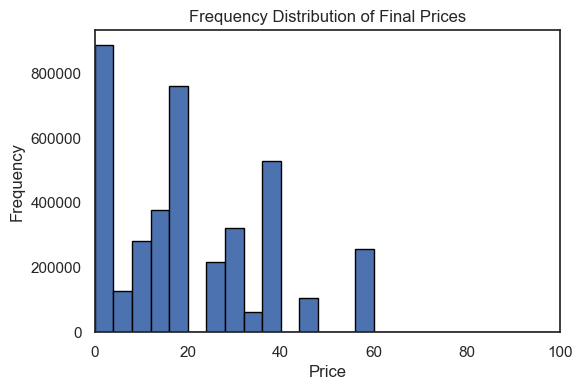

In [84]:
# frequency distribution of final prices

plt.figure(figsize=(10, 5))
plt.figure(dpi=100)
plt.hist(final_df['price_final'], bins=25, edgecolor='black', range=(0, 100))
plt.title('Frequency Distribution of Final Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.xlim(0, 100)
plt.show()

The frequency distribution of final prices shows that most games are under 4.99, 19.99 and 59.99 dollars. 

We also see that there is no game beyond 60 euros.

Cheaper games in the price ranges from 0 to 20 euros dominate the in terms of frequency.


**Boxplot of Final Prices**

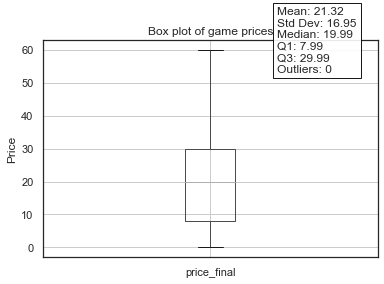

In [85]:
# boxplot of final price

ax = final_df.boxplot('price_final')

ax.set_ylabel('Price')
ax.set_title('Box plot of game prices')

stats = final_df['price_final'].describe()
mean = final_df['price_final'].mean()
std_dev = final_df['price_final'].std()

# calculate outliers
q1 = stats['25%']
q3 = stats['75%']
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

outliers = final_df[(final_df['price_final'] < lower_bound) | (final_df['price_final'] > upper_bound)]['price_final']
num_outliers = outliers.count()

# add statistics to the plot
ax.text(0.7, 0.85, f"Mean: {mean:.2f}\nStd Dev: {std_dev:.2f}\nMedian: {stats['50%']:.2f}\nQ1: {stats['25%']:.2f}\nQ3: {stats['75%']:.2f}\nOutliers: {num_outliers}",
        transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black', alpha=0.9))


plt.show()


**Compatibility of Windows, Mac and Linux**

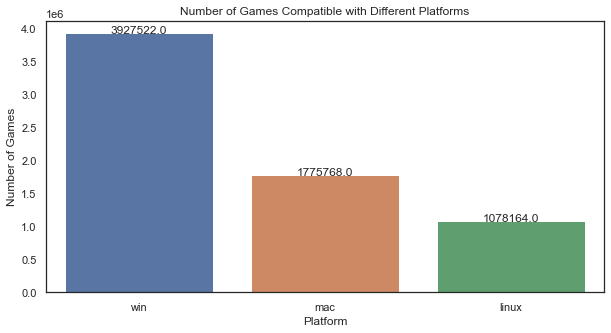

In [39]:
# compatibility with different platforms

# Calculating the number of games compatible with each platform
platform_counts = final_df[['win', 'mac', 'linux']].sum().reset_index()
platform_counts.columns = ['Platform', 'Count']

plt.figure(figsize=(10, 5))

ax = sns.barplot(x='Platform', y='Count', data=platform_counts)

plt.title('Number of Games Compatible with Different Platforms')
plt.xlabel('Platform')
plt.ylabel('Number of Games')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.show()

In [40]:
# Calculate the number of games supporting each combination of platforms (windows, mac, linux)

win_only = ((final_df['win'] == True) & (final_df['mac'] == False) & (final_df['linux'] == False)).sum()
win_mac = ((final_df['win'] == True) & (final_df['mac'] == True) & (final_df['linux'] == False)).sum()
win_linux = ((final_df['win'] == True) & (final_df['mac'] == False) & (final_df['linux'] == True)).sum()
win_mac_linux = ((final_df['win'] == True) & (final_df['mac'] == True) & (final_df['linux'] == True)).sum()
mac_only = ((final_df['win'] == False) & (final_df['mac'] == True) & (final_df['linux'] == False)).sum()
linux_only = ((final_df['win'] == False) & (final_df['mac'] == False) & (final_df['linux'] == True)).sum()

print(f"Number of games supporting only Windows: {win_only}")
print(f"Number of games supporting Windows and Mac: {win_mac}")
print(f"Number of games supporting Windows and Linux: {win_linux}")
print(f"Number of games supporting Windows, Mac, and Linux: {win_mac_linux}")
print(f"Number of games supporting only Mac: {mac_only}")
print(f"Number of games supporting only Linux: {linux_only}")

Number of games supporting only Windows: 2079743
Number of games supporting Windows and Mac: 769615
Number of games supporting Windows and Linux: 72011
Number of games supporting Windows, Mac, and Linux: 1006153
Number of games supporting only Mac: 0
Number of games supporting only Linux: 0


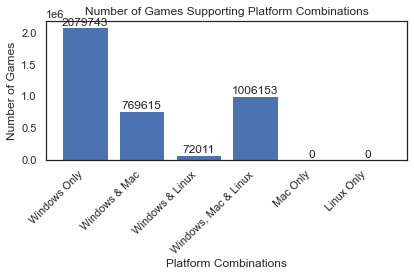

In [41]:
# Platform combinations and their counts

platform_combinations = {
    "Windows Only": win_only,
    "Windows & Mac": win_mac,
    "Windows & Linux": win_linux,
    "Windows, Mac & Linux": win_mac_linux,
    "Mac Only": mac_only,
    "Linux Only": linux_only,
}

fig, ax = plt.subplots()
ax.bar(platform_combinations.keys(), platform_combinations.values())

# Add the counts above the bars
for i, (combination, count) in enumerate(platform_combinations.items()):
    ax.text(i, count + 10, f"{count}", ha='center', va='bottom')

ax.set_title("Number of Games Supporting Platform Combinations")
ax.set_xlabel("Platform Combinations")
ax.set_ylabel("Number of Games")

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Windows definitly dominates, when it comes to the number of games it supports. Most developers only develop for windows. However, there are still many games which run on windows, mac and linux. These results tell us that we should consider a users operating system, when recommending a game based on a user_id.

**Trends in game releases, user reviews, and ratings over time**

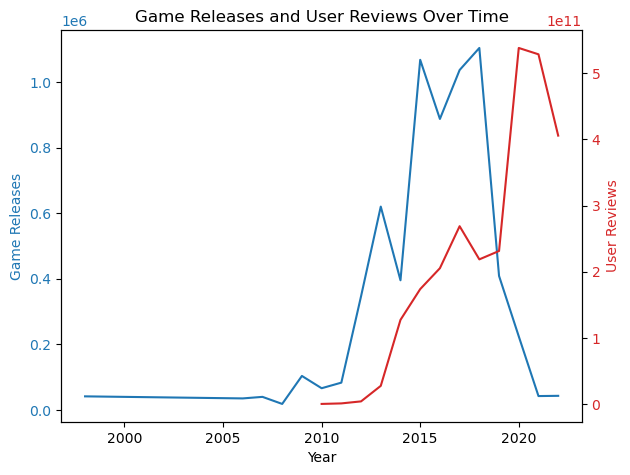

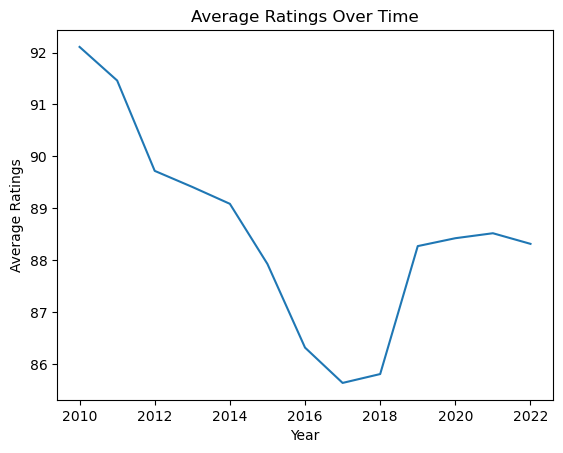

In [10]:
# Trends in game releases, user reviews, and ratings over time

final_df['date_release'] = pd.to_datetime(final_df['date_release'])
final_df['date'] = pd.to_datetime(final_df['date'])

game_releases_by_year = final_df.groupby(final_df['date_release'].dt.year).size()
user_reviews_by_year = final_df.groupby(final_df['date'].dt.year)['user_reviews'].sum()
avg_ratings_by_year = final_df.groupby(final_df['date'].dt.year)['positive_ratio'].mean()

fig, ax1 = plt.subplots()

ax1.set_xlabel('Year')
ax1.set_ylabel('Game Releases', color='tab:blue')
ax1.plot(game_releases_by_year.index, game_releases_by_year, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('User Reviews', color='tab:red')
ax2.plot(user_reviews_by_year.index, user_reviews_by_year, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Game Releases and User Reviews Over Time')
plt.show()

plt.plot(avg_ratings_by_year.index, avg_ratings_by_year)
plt.xlabel('Year')
plt.ylabel('Average Ratings')
plt.title('Average Ratings Over Time')
plt.show()

On average, the number of game releases has increased from 2006 to 2022. There where several drop in 2013, 2018 and 2020. The last drop is most likely due to the Covid-19 pandemic. User started reviewing games since 2010. The number of reviews has strongly increased since then.

The average ratings over time have decreased from 93 in the year 2010 to 84 in 2018. Later it increased again to a rating of 84 in the year 2022. 

These results could be due to the following reasons:

Game Releases: The plot shows an increase in the number of game releases from 2006 to 2022. 
This could be attributed to several factors such as:
- Growing popularity of gaming: As gaming continues to gain popularity as a form of entertainment, more game developers are entering the market, leading to an increase in the number of game releases.
- Ease of developing and distributing games: With the rise of digital distribution platforms, it has become easier for game developers to develop and distribute games, which has led to an increase in the number of game releases.
- Advances in technology: The increasing availability of advanced game engines, tools, and resources has made it easier for game developers to create and release games.

User Reviews: The plot shows an increase in the number of user reviews since 2010. 
This could be attributed to several factors such as:
- Rise of online platforms: The rise of online platforms such as Steam, GOG, and Itch.io has made it easier for users to share their experiences and opinions on games.
- Social media: The increasing use of social media has made it easier for users to connect with each other and share their experiences with games, leading to an increase in user reviews.
- Importance of user feedback: Game developers have increasingly recognized the importance of user feedback in improving the quality of games, leading to an increase in the number of user reviews.

Average Ratings: The plot shows a decrease in average ratings from 2010 to 2018, followed by an increase in ratings from 2018 to 2022. 
This could be attributed to several factors such as:
- Increased competition: With more games being released every year, there is increased competition among game developers to produce high-quality games, which could have led to a decline in average ratings from 2010 to 2018.
- Changing user preferences: User preferences for games may have changed over time, leading to a decline in ratings for certain types of games.
- Increased focus on quality: Game developers may have focused more on improving the quality of their games in recent years, leading to an increase in average ratings from 2018 to 2022.

## Feature Engineering

In [20]:
def extra_features(X, add_elapsed = True):
    
    if add_elapsed:
        elapsed_time = X["date"] - X["date_release"]

### Creating New Features

**Rec System Input**

In [ ]:
final_df

**Elapsed Time:** A new feature which tracks the amount of time that has elapsed between the game's release and the review being logged. This could be interested because people who purchase a game right after its release are likely to be larger fans of the genre or franchise.

In [65]:
final_df["elapsed_time"] = final_df["date"] - final_df["date_release"]

# number of products with discount
# pertentage of products with discount

**Relative Recommendation:** Find the rate at which users rated a game positively (out of the count of games they have rated). Then, find for each review whether a recommendation is in line with user's typical reviews or not.

In [66]:
# Count the number of reviews per user and rename column
usr_rating_count = final_df[["user_id","y"]].groupby("user_id").count()
usr_rating_count.rename(columns = {"y":"review_count"}, inplace = True)

# Find the number of positive reviews
usr_rating_count["positive_reviews"] = final_df[["user_id","y"]].groupby("user_id").sum()

# Find how many reviews out of total are positive
usr_rating_count["positive_rate"] = usr_rating_count["positive_reviews"] / usr_rating_count["review_count"]

In [67]:
# Merge review_count and positive_rate to the final_df
final_df = final_df.merge(usr_rating_count.reset_index()[["user_id", "review_count", "positive_rate"]], 
                          how = "left", on = "user_id")

# Use these to create an ulterior feature with recommendation relative to average recommendation
final_df["relaitve_rec"] = (final_df["y"] - final_df["positive_rate"])

**Tendency to Review:** People who review more often tend to...

In [68]:
# Find Review Tendency
final_df["review_tendency"] =  final_df["reviews"] /final_df["products"] 

# Find Tendency Relative to Median Because of Low Values
final_df["rel_review_tendency"] = (final_df["review_tendency"] - final_df["review_tendency"].median())/ final_df["review_tendency"].median()


**Positive & Negative Reviews:** Here we calculate the number of positive and negative reviews for each game. This is done through the positive_ratio column.

In [69]:
final_df["positive_reviews"] = final_df["positive_ratio"] * final_df["user_reviews"]
final_df["negative_reviews"] = (1 - final_df["positive_ratio"]) * final_df["user_reviews"]

In [70]:
final_df.head(2)

app_id  helpful  funny       date      y  hours  user_id  review_id  \
0  304390        4      0 2017-02-17  False   11.5      797          1   
1  304390        2      0 2017-03-23  False  180.6   103506         26   

        title date_release  ...  products  reviews  elapsed_time review_count  \
0  FOR HONOR™   2017-02-13  ...        40        1        4 days            1   
1  FOR HONOR™   2017-02-13  ...        10        1       38 days            2   

   positive_rate  relaitve_rec  review_tendency  rel_review_tendency  \
0            0.0           0.0            0.025                0.025   
1            0.0           0.0            0.100                3.100   

   positive_reviews  negative_reviews  
0           5172828          -5096757  
1           5172828          -5096757  

[2 rows x 43 columns]

## Additional Data Exploration after Feature Engeneering

**Exploration of elapsed time**

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter out rows with negative elapsed time
final_df = final_df[final_df['elapsed_time'].dt.days >= 0]

# Calculate the average 'elapsed_time_days' for each unique review date
average_elapsed_time = final_df.groupby('date')['elapsed_time'].mean().reset_index()

# Set the 'date' column as the index
average_elapsed_time.set_index('date', inplace=True)

# Convert the elapsed time to days
average_elapsed_time['elapsed_time'] = average_elapsed_time['elapsed_time'].dt.days

# Resample the data to a monthly frequency and calculate the moving average
monthly_moving_average = average_elapsed_time.resample('M').mean().rolling(window=1).mean()

# Plot the average 'elapsed_time_days' and the monthly moving average over time
plt.figure(figsize=(10, 6))
#plt.plot(average_elapsed_time, label='Average Elapsed Time (Days)')
plt.plot(monthly_moving_average, label='Monthly Moving Average', linewidth=2, color='red')
plt.xlabel('Date')
plt.ylabel('Average Elapsed Time (Days)')
plt.title('Average Elapsed Time Over Time (with Monthly Moving Average)')
plt.legend()
plt.show()


The plot shows that the average elapsed time increases on average from 2012 to 2022.

One possible reason for the increase in the average elapsed time over the years could be the increase in the number of games being released on the Steam platform over time.

As the number of games being released increases, the number of reviews being posted for each game is also likely to increase, leading to a larger number of reviews for games that have been released more recently. This, in turn, could lead to a higher average elapsed time for reviews, as more recent games would have less time for reviews to be posted compared to older games.

Additionally, as the number of games on the platform increases, the average age of games being reviewed is likely to decrease. Newer games are more likely to be reviewed closer to their release date than older games, which may also contribute to the increase in the average elapsed time for reviews.

In [139]:
unique_discounts = final_df['discount'].unique()
print(unique_discounts)

[ 0. 90. 50. 60. 75. 85.]


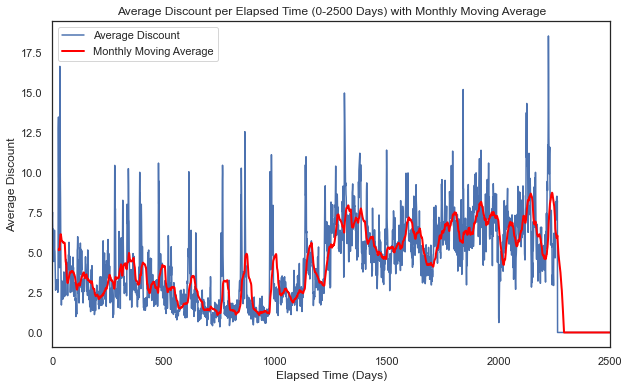

In [143]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter out rows with negative elapsed time and limit the range to 0-2500 days
final_df = final_df[(final_df['elapsed_time'].dt.days >= 0) & (final_df['elapsed_time'].dt.days <= 2500)]

# Convert the elapsed time to days
final_df['elapsed_time_days'] = final_df['elapsed_time'].dt.days

# Group by 'elapsed_time_days' and calculate the mean discount for each group
average_discount_per_elapsed_time = final_df.groupby('elapsed_time_days')['discount'].mean().reset_index()

# Set the 'elapsed_time_days' column as the index
average_discount_per_elapsed_time.set_index('elapsed_time_days', inplace=True)

# Calculate the moving average using a rolling window of approximately 30 days
monthly_moving_average = average_discount_per_elapsed_time.rolling(window=30).mean()

# Create the line plot with the monthly moving average
plt.figure(figsize=(10, 6))
plt.plot(average_discount_per_elapsed_time, label='Average Discount')
plt.plot(monthly_moving_average, label='Monthly Moving Average', linewidth=2, color='red')
plt.xlabel('Elapsed Time (Days)')
plt.ylabel('Average Discount')
plt.title('Average Discount per Elapsed Time (0-2500 Days) with Monthly Moving Average')
plt.xlim(0, 2500)
plt.legend()
plt.show()


In [ ]:
# rel_review_tendency

# more reviews more objective higher quality
# ratio of positive reviews

#### Model Preparation

In [ ]:
column_names = final_df.columns.tolist()
print(column_names)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
subset_df = final_df.sample(n=50000, random_state=42)
subset_df.head(3)

#### Logistic Regression Model

**Comment:** L1 Regularization preferred to L2

In [ ]:
# Consider balancing out data because of overwhelming positivity

In [ ]:
print(subset_df['y'].value_counts(normalize=True))

In [ ]:
# linear model
X = subset_df.drop(['y'], axis=1)  # Use all columns except 'y' as features
y = subset_df['y']  # Use 'y' as the target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

num_features = ['price_final', 'positive_ratio', 'hours', 'median_playtime']

preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), num_features)])

model = LinearRegression()

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)

print("Cross-validation R^2:", np.mean(cv_scores))

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)

mse = mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
r2 = pipeline.score(X_train, y_train)

print("\nMSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)

In [ ]:
# Update features
num_features += ['reviews', 'products', 'discount']

# Update preprocessor
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), num_features)])

# Fit preprocessor
preprocessor.fit(X_train)

# Update pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

# Adjust alpha with GridSearchCV
param_grid = {'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Report the average score with the best hyperparameter
print(f"Best average R^2 score: {grid_search.best_score_:.4f}")
print(f"Best hyperparameter: {grid_search.best_params_}")

# Check if the model performance improved
improved = grid_search.best_score_ > np.mean(cv_scores)
print(f"Model performance improved: {improved}")

# Feature importance
best_model = grid_search.best_estimator_.named_steps['model']
feature_importances = np.abs(best_model.coef_)

feature_names = num_features

# Top 5 features
top_5_features_idx = np.argsort(feature_importances)[-5:]
top_5_features = [feature_names[i] for i in top_5_features_idx]
print(f"Top 5 features: {top_5_features}")

# Unuseful features (defined as features with importance close to zero)
threshold = 1e-5
low_importance = feature_importances < threshold
unuseful_features = np.array(feature_names)[low_importance]
print(f"Unuseful features: {unuseful_features.tolist()}")


In [ ]:
# logistic model

X = subset_df.drop(['y'], axis=1)  # Use all columns except 'y' as features
y = subset_df['y']  # Use 'y' as the target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

num_features = ['price_final','positive_ratio', 'hours', 'median_playtime']

preprocessor = ColumnTransformer(
    transformers=[ ('num', StandardScaler(), num_features)])

model = LogisticRegression(penalty='l2', random_state=42)

pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', model)])

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print("Cross-validation accuracy:", np.mean(cv_scores))


pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)

accuracy = accuracy_score(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)

print("\n""Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

In [ ]:
# Update features
num_features += ['reviews', 'products', 'discount']

# Update preprocessor
preprocessor = ColumnTransformer(
    transformers=[ ('num', StandardScaler(), num_features)])

# Fit preprocessor
preprocessor.fit(X_train)


# Logistic regression with L1
model = LogisticRegression(penalty='l1', solver='liblinear')


# Update pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])


# Adjust alpha with GridSearchCV   # C = 1/alpha
param_grid = {'model__C': [1/0.001, 1/0.01, 1/0.1, 1/1]} 


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Report the average score with the best hyperparameter
print(f"Best average accuracy score: {grid_search.best_score_:.4f}")
print("\n"f"Best hyperparameter: {grid_search.best_params_}")

# Check if the model performance improved
improved = grid_search.best_score_ > np.mean(cv_scores)
print("\n"f"Model performance improved: {improved}")

# Feature importance
best_model = grid_search.best_estimator_.named_steps['model']
feature_importances = np.abs(best_model.coef_[0])

feature_names = num_features

# Top 5 features
top_5_features_idx = np.argsort(feature_importances)[-5:]
top_5_features = [feature_names[i] for i in top_5_features_idx]
print("\n"f"Top 5 features: {top_5_features}")


# Unuseful features (defined as features with importance of zero)
zero_importance = feature_importances == 0
unuseful_features = np.array(feature_names)[zero_importance]
print(f"Unuseful features: {unuseful_features.tolist()}")

In [ ]:
# 309821
# 2867728
# 51774

#### Recommendation System

In [ ]:
# Train the logistic regression model
numeric_features = ['price_final','positive_ratio', 'hours', 'median_playtime', 'reviews', 'products', 'discount']
categorical_features = ['win', 'mac', 'linux']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)])

model = LogisticRegression(random_state=42)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

X = final_df.drop(columns=['y'])
y = final_df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

pipeline.fit(X_train, y_train)

# Function to recommend a game to a user
def recommend_game(user_id, all_games, n_recommendations=1):
    
    # Get user's reviewed games
    user_games = all_games[all_games['user_id'] == user_id]
    
    if user_games.empty:
        print("User not found.")
        return
    
    # Get the user's operating system
    user_os = []
    if user_games['win'].iloc[0]:
        user_os.append('win')
    if user_games['mac'].iloc[0]:
        user_os.append('mac')
    if user_games['linux'].iloc[0]:
        user_os.append('linux')
    
    # Filter games that the user hasn't reviewed
    unreviewed_games = all_games.drop(user_games.index)
    
    # Filter games that match the user's operating system
    compatible_games = unreviewed_games[unreviewed_games[user_os].any(axis=1)]
    
    # Get recommendation scores
    X_unreviewed = compatible_games.drop(columns=['y'])
    
    recommendation_scores = pipeline.predict_proba(X_unreviewed)[:, 1]
    # print(recommendation_scores)
    # Get top n_recommendations indices
    top_indices = np.argsort(recommendation_scores)[-n_recommendations:]

    # Get the recommended game
    recommended_games = compatible_games.iloc[top_indices].reset_index(drop=True)
    recommended_game = recommended_games.loc[0, ['title', 'price_final']]
    
    return recommended_game

# Input user ID and get a game recommendation
user_id = int(input("Enter a user ID: "))
recommended_game = recommend_game(user_id, final_df)
print(recommended_game)
